# Import Packages

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../PycastWorld")
sys.path.append("../Gym")
from gym_pycastworld.PycastWorldEnv import PycastWorldEnv

sys.path.append("../Automator")
from AutoGen import Navigator

from fastai.vision.all import *
from fastbook import *
import datetime;

import sys
import fastprogress
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
# sys.path.append("../PycastWorld")
# from gym_pycastworld.PycastWorldEnv import PycastWorldEnv  # type: ignore

# Initialize environment

In [2]:
env = PycastWorldEnv()

# Grab the initial observation (not used here)
observation = env.reset()

# Random action selection. This should be done in some
# sort of "intelligent" manner.
action = env.action_space.sample()

# Advance the world one step. We could also have the step
# method advance more than step so that it takes fewer
# steps in total to get to the end goal.
observation, reward, done, info = env.step(action)

# Check if we reached the end goal
if done:
    print(f"  Found goal in {t+1} steps")

print(f"  Ended at position {env.world.getX()}, {env.world.getY()}")
env.close()

  Ended at position 3.5, 3.5


In [7]:
dir(env.world)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'atGoal',
 'direction',
 'getDirX',
 'getDirY',
 'getTurnSpeed',
 'getWalkSpeed',
 'getX',
 'getY',
 'position',
 'render',
 'reset',
 'savePNG',
 'turn',
 'update',
 'walk']

In [8]:
import sys
sys.path.append("../Utilities")
from MazeUtils import read_maze_file, percent_through_maze



In [9]:
env.world.atGoal()

False

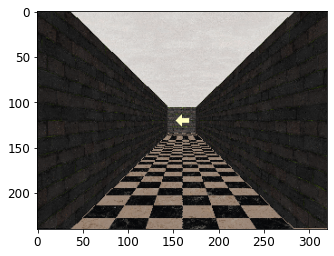

In [3]:
plt.imshow(observation)

## Set Position

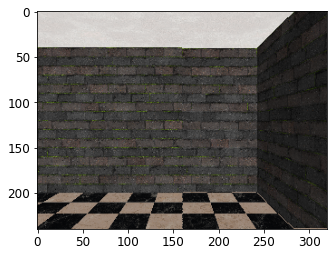

In [47]:
env.reset()
env.world.position(6.5, 3.5, 0)
observation = env.render(mode='rgb_array')
plt.imshow(observation)

## Moving

### Turn Left

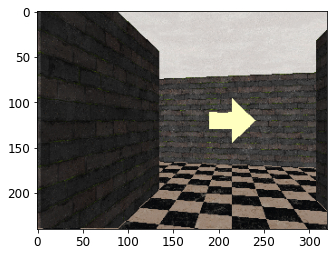

In [53]:
observation, reward, done, info = env.step(0)
plt.imshow(observation)

### Move Forward

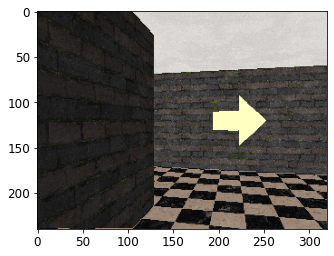

In [59]:
observation, reward, done, info = env.step(1)
plt.imshow(observation)

### Turn Right

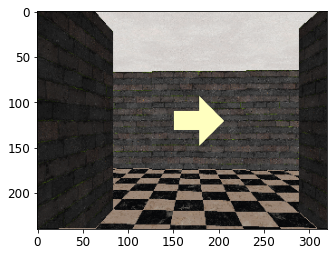

In [63]:
observation, reward, done, info = env.step(2)
plt.imshow(observation)

## Reset Environment

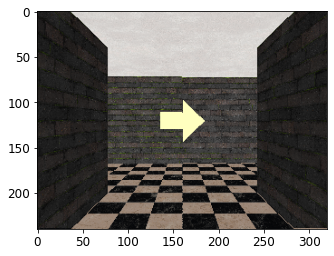

In [64]:
observation = env.reset()
plt.imshow(observation)

### Print Position

  Ended at position 3.5, 3.5


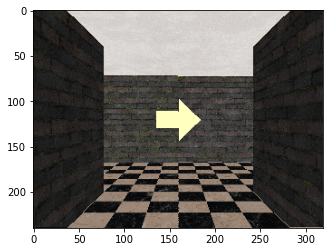

In [20]:
plt.imshow(observation)
print(f"  Ended at position {env.world.getX()}, {env.world.getY()}")

## List environment methods

In [39]:
dir(env.world);

# Collecting Data

Below is a code chunk that utilize the AutoGen.py, a program written by Jared, which automatically runs the game and saves the camera's images into three directories: left, right, and straight. 

- Do we care if the images are downloaded in sequential order?
- While running the AutoGen.py the robot gets stuck. That is, the program is running forever at a particular step in the directions. 
- maze.txt AutoGen run
	- looks like it gets stuck in last step? 
	- saved 5202 in straight, 318 in left, and 384 in right images on first run
	- AutoGen finished running after second run
		- 816 in straight, 155 in left, 228 in right
- new_maze.txt Autogen
    - finished running and added 585 images to straight, 101 to left, and 38 in right (i think that makes sense acutally because new_maze only had one WEST direction)??
- new_maze2.txt 
    - Looks like the robot gets stuck more easily. Maybe there's a way to graphically show this. Might need to adjust AutoGen ranomization
    
- new dataset build over weekend: 
    - saved about 4157 in straight, which has the most compared to left and right

In [3]:
# maze = sys.argv[1] if len(sys.argv) > 1 else "../Worlds/maze.txt"
# img_dir = sys.argv[2] if len(sys.argv) > 2 else None
maze = "../Worlds/maze.txt"
img_dir = "../Notebooks/data"
show_freq = 0

navigator = Navigator(maze, img_dir)

j = 0
while j < navigator.num_directions - 1:
    navigator.navigate(j, show_dir=True, show_freq=show_freq)
    j += 1
print(j)

Directions: 1, 3, Dir.NORTH
Directions: 1, 5, Dir.NORTH
Directions: 1, 7, Dir.NORTH
Directions: 1, 9, Dir.EAST
Directions: 3, 9, Dir.NORTH
Directions: 3, 11, Dir.NORTH


KeyboardInterrupt: 

In [4]:
dir_types = 'left','right','straight'
path = Path('../Notebooks/data')

## Size of trained dataset on 10 mazes: 

In [6]:
!ls -l ../Notebooks/data/left | wc -l

3461


In [7]:
!ls -l ../Notebooks/data/right | wc -l

3511


In [8]:
!ls -l ../Notebooks/data/straight | wc -l

12612


In [5]:
if not path.exists():
    path.mkdir()
    for o in dir_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} data')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
path.ls()

(#4) [Path('../Notebooks/data/left'),Path('../Notebooks/data/.ipynb_checkpoints'),Path('../Notebooks/data/right'),Path('../Notebooks/data/straight')]

In [7]:
lefts = (path/'left').ls().sorted()
rights = (path/'right').ls().sorted()
straights = (path/'straight').ls().sorted()

# Model Building

In [8]:
# dls = ImageDataLoaders.from_folder(path) # expects train and validate folder 

# should work with cur dir hierarchy
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(128)) 

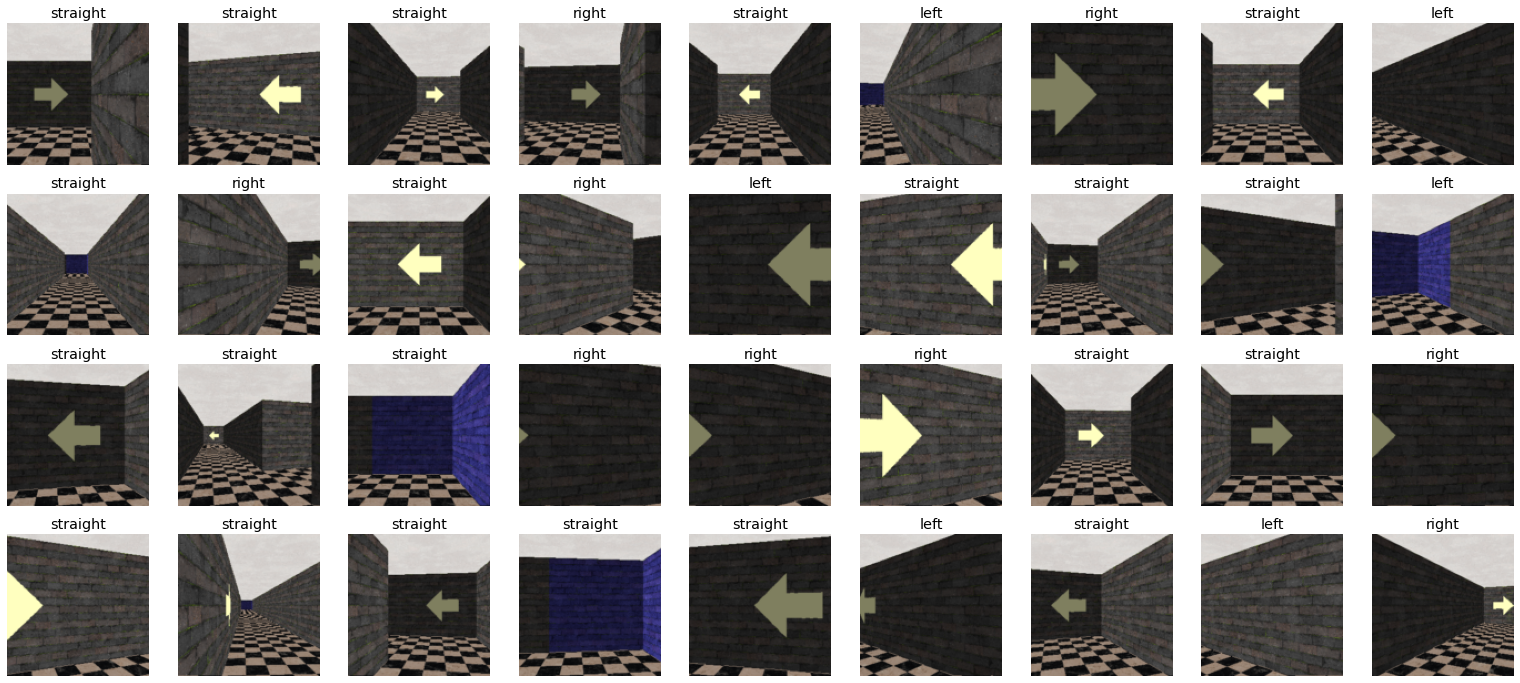

In [9]:
dls.valid.show_batch(max_n=36, nrows=4)

In [19]:
dls.train_ds.loss_func

FlattenedLoss of CrossEntropyLoss()

## Model trained on 15 mazes

In [10]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.608941,0.445049,0.135047,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.333630,0.293007,0.099766,00:23


## Model Diagnostics

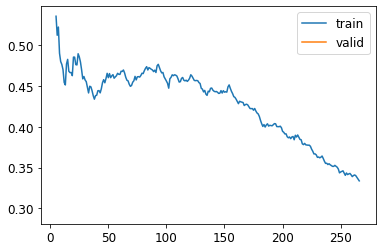

In [11]:
learn.recorder.plot_loss()

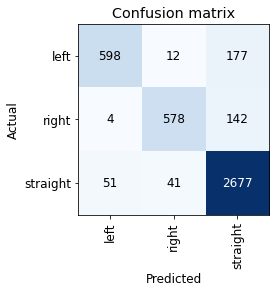

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix() # tell fastai we have an inbalance in our training set: loss weighting
# learn.shape

In [36]:
interp.plot_top_losses(9) # look into deleting scurious images

NameError: name 'interp' is not defined

In [40]:
learn.model;

In [46]:
'''
look at [1][8]. this is 3 neurons that represent our 3 classes. 
take that output of [1][8]
and concatenate it with another linear

might want to plug in new neuron in flatten and concatenate 

make the very first additional data straight
'''
learn.model[1][8];

## Export the Model

In [94]:
learn.export(fname="learner_" + str(datetime.datetime.now()) + ".pkl")

In [15]:
path = Path('../Models')
path.ls(file_exts='.pkl')

(#11) [Path('../Models/auto-stack-c-large.pkl'),Path('../Models/auto-gen-c_large-6-6.pkl'),Path('../Models/learner_2021-06-01 16:40:23.194027.pkl'),Path('../Models/auto-gen-r_plus.pkl'),Path('../Models/auto-gen-c.pkl'),Path('../Models/auto-gen-r_large-6-6.pkl'),Path('../Models/auto-gen-c_plus.pkl'),Path('../Models/auto-stack-r.pkl'),Path('../Models/auto-stack-c.pkl'),Path('../Models/auto-gen-r.pkl')...]

## Apply Model

In [16]:
steps_per_episode = 1500

env = PycastWorldEnv()

# Run some number of trials all starting from the
# initial location. We might eventually randomize
# the maze and the starting location.

# Grab the initial observation (not used here)
observation = env.reset()
frames = [observation.copy()]
model_inf = load_learner(path/'auto-gen-c_large-6-6.pkl')

In [17]:
%%capture
start = time.time()
print("Predicting...")
# learn.recorder.silent = True
for t in range(steps_per_episode):    
    # Use a trained CNN to select the action
    action_name, action_index, action_probs =  model_inf.predict(observation);    
    # map 2 to 1
    if action_index == 2:
        action_index = 1
    elif action_index == 1:
        action_index = 2

    # Advance the world one step. We could also have the step
    # method advance more than step so that it takes fewer
    # steps in total to get to the end goal.
    observation, reward, done, info = env.step(action_index)
    frames.append(observation.copy())

    # Check if we reached the end goal
    if done:
        print(f"  Found goal in {t+1} steps")
        break

print(f"  Ended at position {env.world.getX()}, {env.world.getY()}")
env.close();
end = time.time()
print ("Time elapsed:", end - start)

# Animate frames

## Save Animation as a GIF

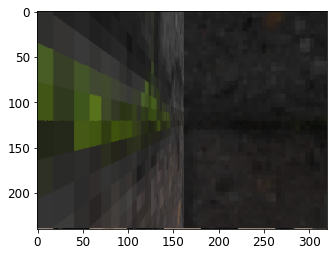

In [26]:
fig, ax = plt.subplots()
ln = plt.imshow(frames[0])
def init():
    ln.set_data(frames[0])
    return [ln]

def update(frame):
#     print(frame)
    ln.set_array(frame)
    return [ln]

ani = FuncAnimation(fig, update, frames, init_func=init, interval=60)
# plt.show()
ani.save("prediction_" + str(datetime.datetime.now()) + ".mp4")

In [13]:
env.world.

NameError: name 'world' is not defined

## View Animation in HTML Representation

In [25]:
smaller_frames = frames[::45] 
ani = FuncAnimation(fig, update, smaller_frames, init_func=init, interval=100)
ani.save('test.mp4') #ani.to_html5